# This notebook generates figure08, which show that thermal resistance is the controlling variable for Ic suppression during irradiation.

In [111]:
%pylab notebook

from scipy.optimize import curve_fit

import sys, os, importlib, warnings, pandas as pd, seaborn as sns
warnings.filterwarnings("ignore")

sys.path.append('/Users/alexisdevitre/Documents/code/hts-irradiation')
import hts_fitting as hts, default_figure_style as dfs, hts_fitfunctions as ff
for lib in [hts, dfs, ff]:
    importlib.reload(lib)


#################################
########## Load data ############
#################################

cols = [0, 1, 9, 10, 12, 13, 14, 19, 23, 25, 27, 29, 39, 41, 43, 45, 52, 53, 54, 55, 56, 57, 58, 59]
names = [
    'tapeid', 
    'anneal',
    'ibeam',
    'ibeam_std',
    'energy', 
    'power', 
    'powerError',
    'ic0',
    'icoff',
    'noff',
    'icon',
    'non',
    
    'tHTS_OFF',
    'tTAR_OFF',
    'tHTS_ON',
    'tTAR_ON',
    
    'tREBCO',
    'degradation',
    'degradationError',
    'suppression', 
    'suppressionError',
    'suppression_corrected',
    'suppressionError_corrected',
    'outlier' 
]
df = pd.read_excel(dfs.master, sheet_name='data', usecols=cols, names=names, skiprows=1)

#################################
########## Filter data ##########
#################################
#cut &= df.installation == 1

cut = df.tTAR_OFF < 20
cut &= (df.suppression != np.nan) & (df.suppression > 0) & (df.suppressionError > 0)
cut &= df.outlier != 1

data = df[cut]

print('\n\nTotal datapoints', data.energy.count())
for tapeid in data.tapeid.unique():
    print('\nDatapoints for', tapeid, data[data.tapeid==tapeid].energy.count())

for energy in data.energy.unique():
    print('\nDatapoints for', energy, data[data.energy==energy].energy.count())
df.columns

outputDirectory = '../figures/raw/'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Total datapoints 656

Datapoints for f33 68

Datapoints for f20 11

Datapoints for f34 9

Datapoints for f29 302

Datapoints for f23 2

Datapoints for f28 58

Datapoints for f37 206

Datapoints for 150 167

Datapoints for 800 136

Datapoints for 2400 129

Datapoints for 1200 224


## Figure 08 description

This figure compares tapes ffj29, ffj37 and ffj33 in terms of the temperature rise in REBCO as a function of ion beam power. There are two additional trend lines for the datasets corresponding to ffj29 and ffj37 after the first anneal. It is observed that the first (and only the first) anneal causes a change in thermal resistance, whose explanation is left for further investigation. The light colored enveloped are the result of 2D thermal modeling, aimed at reproducing the temperature in the tape during irradiation using the sensor temeprature as input and the thermal resistance at the tape/target boundary as the single free parameter. 

<IPython.core.display.Javascript object>


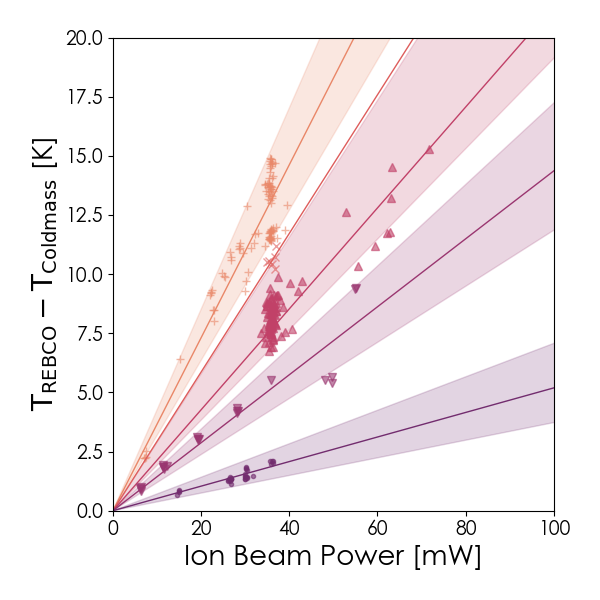

f29-1 Lower bound 1.50 [mK/W] Upper bound 2.40 [mK/W]
f37-1 Lower bound 0.90 [mK/W] Upper bound 1.70 [mK/W]
f37-2 Lower bound 0.50 [mK/W] Upper bound 0.90 [mK/W]
f33-1 Lower bound 0.08 [mK/W] Upper bound 0.18 [mK/W]


In [81]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
fitfunction = ff.affine
xsmooth = np.linspace(0, 200, 1000)

datasets = ['f29-1', 'f29-2', 'f37-1', 'f37-2', 'f33-1'] #, 
energies = [150, 1200, 1200, 150, 150]
markers = ['+', 'x', '^', 'v', '.']
plotModelYN = [True, False, True, True, True]
colors = sns.color_palette('flare', len(datasets))

for dataset, energy, plotModel, m, c in zip(datasets, energies, plotModelYN, markers, colors):
    tape = dataset.split('-')[0]
    
    cut = (data.tapeid == tape)
    cut &= (data.energy == energy)
    if int(dataset.split('-')[1]) > 1:
        cut &= (data.anneal > 1)
    else:
        cut &= (data.anneal == 1)
    cut &= (data.tREBCO-data.tTAR_ON > 0) # Some corrections fail and produce tREBCO = 0, which leads to a negative dT.
    d = data[cut]
    
    # plot the data and affine fit
    x, ex = d.power, d.powerError
    y, ey = d.tREBCO-d.tTAR_ON, np.zeros_like(d.powerError)
    popt, pcov = curve_fit(ff.affine, x, y)
    ax.plot(xsmooth, ff.affine(xsmooth, *popt), color=c, alpha=1, linewidth=1)
    ax.plot(x, y, linestyle='None', linewidth=.5, marker=m, markersize=6, alpha=.6, color=c)
    
    # plot model fit
    if plotModel:
        path_to_files = '../data/fem/{}/{}keV/'.format(dataset, energy)
        minThickness, maxThickness = 100, 0 # find the extreme cases of the simulation 
        for fpath in [path_to_files+f for f in os.listdir(path_to_files) if 'DS_Store' not in f]:
            thickness = float(fpath.split('/')[-1].split('=')[1].split('um+')[0])
            if thickness < minThickness: minThickness = thickness
            if thickness > maxThickness: maxThickness = thickness

        if float(int(minThickness)) == minThickness: minThickness = int(minThickness)
        if float(int(maxThickness)) == maxThickness: maxThickness = int(maxThickness)
        
        print(dataset, 'Lower bound {:<4.2f} [mK/W]'.format(minThickness*1e-1), 'Upper bound {:4.2f} [mK/W]'.format(maxThickness*1e-1))
        
        # get lower bound fit
        fpath = path_to_files+'{}_{}keV_deltaT_Apiezon={}um+Sensorpos=4.96mm.txt'.format(tape, energy, minThickness)
        d = pd.read_csv(fpath, skiprows=5, delim_whitespace=True, names=['ibeam', 'hkapton', 'xsensor', 'dTREBCO', 'dTSensor'])
        x, y = d.ibeam*energy*1e-3, d.dTREBCO
        popt_lower, _ = curve_fit(ff.affine, x, y)

        fpath = path_to_files+'{}_{}keV_deltaT_Apiezon={}um+Sensorpos=4.96mm.txt'.format(tape, energy, maxThickness)
        d = pd.read_csv(fpath, skiprows=5, delim_whitespace=True, names=['ibeam', 'hkapton', 'xsensor', 'dTREBCO', 'dTSensor'])
        x, y = d.ibeam*energy*1e-3, d.dTREBCO
        popt_upper, _ = curve_fit(ff.affine, x, y)

        xsmooth = np.linspace(0, 200, 10000)
        ylower = ff.affine(xsmooth, *popt_lower)
        yupper = ff.affine(xsmooth, *popt_upper)
        ax.fill_between(x=xsmooth, y1=ylower, y2=yupper, color=c, alpha=.2)

ax.set_xlabel('Ion Beam Power [mW]')
ax.set_ylabel('$\mathrm{T_{REBCO} - T_{Cold mass}}$ [K]')
ax.set_xlim(0, 100)
ax.set_ylim(0, 20)
#ax.set_yticks([0, 3, 6, 9, 12, 15, 18])
fig.tight_layout()
#ax.legend()
plt.savefig(outputDirectory+'figure08-thermalResistance.svg', format='svg', facecolor='white')